In [7]:
import os
import pandas as pd
import numpy as np
# ! pip install supervenn
from supervenn import supervenn

import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_dropbox_dir
from standardize import fill_na_by_cohort, standardize_across_cohorts

## Load Important Stuff

### Directories

In [8]:
# %%
dropbox_dir = get_dropbox_dir()
base_dir = os.path.join(dropbox_dir, 'development_CohortCombination','alignment_RCC_2024_Feb_27')

ref_freq = 0.6
input_freq = 0.1
matt_ft_dir = os.path.join(base_dir, 'matt_top_fts')
data_dir = os.path.join(base_dir, 'alignment_id_31', f'merge_reference_freq_th_{ref_freq}_freq_th_{input_freq}')

cohort_ids_to_labels_file = os.path.join(base_dir, 'cohort_ids_to_labels.xlsx')
save_dir = os.path.join(data_dir,'plots')
os.makedirs(save_dir, exist_ok=True)
savefig_params = {'dpi': 300, 'bbox_inches': 'tight', 'pad_inches': 0.05}

### Matt's Features

In [9]:
# %%
matt_ft_files = os.listdir(matt_ft_dir)
matt_ft_files = [f for f in matt_ft_files if f.endswith('.txt')]

matt_ft_dict = {}
for f in matt_ft_files:
    ft_name = f.split('_feats')[0]
    # with open(os.path.join(matt_ft_dir, f), 'r') as file:
    #     ft = file.read().split(', ')
    # if len(ft) == 1:
    with open(os.path.join(matt_ft_dir, f), 'r') as file:
        ft = file.read().splitlines()
        # print(file.read()
    # remove all of the ', and commas from the strings in the list
    ft = [x.strip(',').strip(' ').strip('"').strip("'").strip('\n').strip('\t') for x in ft]
    matt_ft_dict[ft_name] = ft
    # break
    print(ft_name + ': ' + str(len(ft)))

top_10: 10
top_25: 25
168_os_pfs: 168
net_matched: 86


### RCC Target Metabolites

In [10]:
# %%
rcc_peak_info_file = os.path.join(base_dir, 'rcc_result', 'peak_info.csv')
rcc_peak_info_df = pd.read_csv(rcc_peak_info_file, index_col=0)

rcc_peak_info_df = rcc_peak_info_df[rcc_peak_info_df['freq'] >= ref_freq].copy()

print(f'Number of peaks in the reference cohort after {ref_freq} filter: ', rcc_peak_info_df.shape[0])

    
rcc_matched_targets_file = os.path.join(base_dir,'rcc_result', 'matched_targets HILIC POSITIVE ION MODE.csv')
rcc_matched_targets_df = pd.read_csv(rcc_matched_targets_file, index_col=0)
rcc_matched_targets_df.loc[rcc_peak_info_df.index]

potential_feats = rcc_matched_targets_df[rcc_matched_targets_df['potential_target']].index.to_list()
print('Number of features that potentially match to a target metabolite: ', len(potential_feats))

double_match_ids = rcc_matched_targets_df[rcc_matched_targets_df['potential_target_count'] > 1]
num_double_match = double_match_ids.shape[0]
print('Number of features that potentially match to more than one target metabolite: ', double_match_ids.shape[0])
print(rcc_matched_targets_df.loc[double_match_ids.index, 'potential_target_id'])

# here are the double matches in RCC, two are the same metabolite (but different adducts?)
# FT3202                           tryptophanTryptophan_μM
# FT3237                           kynurenineKynurenine_μM
# FT8451    C18:1 LPC plasmalogen_AC18:1 LPC plasmalogen_B


potential_feat_names = rcc_matched_targets_df.loc[potential_feats]['potential_target_id'].unique()
# print('Number of potential feature names: ', len(potential_feat_names))
print(potential_feat_names)

print('Number of target metabolite captured: ', len(potential_feat_names))

# for now don't remove the double counts, since they are NOT actually double counts
num_rcc_targets_found =  len(potential_feat_names)
rcc_target_feats = potential_feats

# add to the matt ft dictionary
matt_ft_dict['rcc_targets'] = rcc_target_feats


Number of peaks in the reference cohort after 0.6 filter:  4016
Number of features that potentially match to a target metabolite:  188
Number of features that potentially match to more than one target metabolite:  3
feats
FT3202                           tryptophanTryptophan_μM
FT3237                           kynurenineKynurenine_μM
FT8451    C18:1 LPC plasmalogen_AC18:1 LPC plasmalogen_B
Name: potential_target_id, dtype: object
['trimethylamine-N-oxide' 'alanine' 'GABA' 'serine' 'hypotaurine'
 'cytosine' 'creatinine' 'betaine' 'threonine' 'niacinamide' 'taurine'
 'ornithine' 'N-acetylalanine' 'N-carbamoyl-beta-alanine'
 'N-methylproline' 'leucine' 'hydroxyproline' 'N-acetylputrescine'
 '1-methylnicotinamide' 'trigonelline' 'anthranilic acid' 'urocanic acid'
 'imidazole propionate' 'ectoine' 'proline-betaine' 'glutamate'
 '4-acetamidobutanoate' 'butyrobetaine' 'glutamine' 'lysine' 'methionine'
 'N1-methyl-2-pyridone-5-carboxamide' '4-hydroxy-3-methylacetophenone'
 'guanine' 'allantoin

In [11]:
# Helper functions to finding the number and percentage of captured features
def get_captured_fts(matt_ft_list, align_ft_list):
    captured_fts = [ft for ft in matt_ft_list if ft in align_ft_list]
    return captured_fts

def get_captured_perc(matt_ft_list, align_ft_list):
    captured_fts = get_captured_fts(matt_ft_list, align_ft_list)
    matt_capture_perc = len(captured_fts) / len(matt_ft_list)
    align_capture_perc = len(captured_fts) / len(align_ft_list)
    return matt_capture_perc, align_capture_perc


# check that the Matt feats are found in the RCC peaks
print('In the original RCC dataset at the {} frequency threshold:'.format(ref_freq))
for matt_ft_name, matt_ft_list in matt_ft_dict.items():
    captured_peaks = get_captured_fts(matt_ft_list, rcc_peak_info_df.index)
    print(f'Number of {matt_ft_name} captured: {len(captured_peaks)} out of {len(matt_ft_list)}')


In the original RCC dataset at the 0.6 frequency threshold:
Number of top_10 captured: 10 out of 10
Number of top_25 captured: 25 out of 25
Number of 168_os_pfs captured: 168 out of 168
Number of net_matched captured: 86 out of 86
Number of rcc_targets captured: 162 out of 188


## Prep Data

In [12]:
# %%
cohort_id_file = os.path.join(data_dir, 'combined_study_cohort_ids.csv')
nan_mask_file = os.path.join(data_dir, 'combined_study_nan_mask.csv')
combined_study_file = os.path.join(data_dir, 'combined_study.csv')
align_score_file = os.path.join(data_dir, 'align_score_df.csv')
align_feats_file = os.path.join(data_dir, 'alignment_df.csv')


umap_file = os.path.join(data_dir, 'umap_df_zscore.csv')
pca_file = os.path.join(data_dir, 'pca_df_zscore.csv')

cohorts_to_rem = ['549']
print('removing cohorts: ', cohorts_to_rem)

removing cohorts:  ['549']


In [13]:
# %%
# Create the pretraining metadata
if '.csv' in cohort_ids_to_labels_file:
    cohort_ids_to_labels_df = pd.read_csv(cohort_ids_to_labels_file, index_col=0)
elif '.xlsx' in cohort_ids_to_labels_file:
    cohort_ids_to_labels_df = pd.read_excel(cohort_ids_to_labels_file, index_col=0)
else:
    raise ValueError('cohort_ids_to_labels_file must be a csv or xlsx file')

cohort_id_df = pd.read_csv(cohort_id_file, index_col=0)
cohort_id_df.set_index('file_name', inplace=True)
cohort_id_df.columns = ['cohort_id']
metadata_df = cohort_id_df.join(cohort_ids_to_labels_df, on='cohort_id')
# turn the cohort id into a string
metadata_df['cohort_id'] = metadata_df['cohort_id'].astype(str)


metadata_df = metadata_df[~metadata_df['cohort_id'].isin(cohorts_to_rem)]


study_id_to_label = metadata_df.groupby('Study ID')['Cohort Label'].first().to_dict()
cohort_id_to_label = metadata_df.groupby('cohort_id')['Cohort Label'].first().to_dict()
cohort_id_to_study_id = metadata_df.groupby('cohort_id')['Study ID'].first().to_dict()

# %%
# information about the reference cohort
ref_cohort_id = '541'
num_ref_cohort_peaks = rcc_peak_info_df.shape[0]
#TODO Save the number of peaks in the reference cohort used for alignment

# %%
# Get the alignment scores
align_scores = pd.read_csv(align_score_file, index_col=0)
align_scores.index = align_scores.index.astype(str)


cohort_id_to_align_score = align_scores.iloc[:,0].to_dict()
cohort_id_to_align_score[ref_cohort_id] = 1.0

# %%
# Create the unique color maps to consistent plotting across the different plots

# join the following colormaps Accent, Dark2, Set2, Pastel2
my_32_colors = plt.cm.Accent.colors + plt.cm.Dark2.colors + plt.cm.Set2.colors + plt.cm.Pastel2.colors
my_10_colors = plt.cm.tab10.colors
my_20_colors = plt.cm.tab20.colors 
my_42_colors = my_10_colors + my_32_colors
my_52_colors = my_20_colors + my_32_colors

def get_color_map(n):
    if n <= 10:
        return my_10_colors
    elif n <= 20:
        return my_20_colors
    elif n <= 32:
        return my_32_colors
    elif n <= 42:
        return my_42_colors
    elif n <= 52:
        return my_52_colors
    else:
        # create a colormap from turbo
        return plt.cm.turbo(np.linspace(0, 1, n))
    
def assign_color_map(unique_vals):
    my_colors = get_color_map(len(unique_vals))
    color_map = dict(zip(np.sort(unique_vals), my_colors))
    return color_map

# %%
# Create cohort ids for the RCC subsets
rcc1_files = [f for f in metadata_df.index if 'RCC_HP' in f]
print(len(rcc1_files))
rcc3_files = [f for f in metadata_df[metadata_df['cohort_id']==ref_cohort_id].index if 'RCC_HP' not in f]
print(len(rcc3_files))

metadata_df['Cohort ID Expanded'] = metadata_df['cohort_id']
metadata_df['Study ID Expanded'] = metadata_df['Study ID']
metadata_df.loc[rcc1_files, 'Cohort ID Expanded'] = 'RCC1'
metadata_df.loc[rcc3_files, 'Cohort ID Expanded'] = 'RCC3'
metadata_df.loc[rcc1_files, 'Study ID Expanded'] = 'ST001236'
metadata_df.loc[rcc3_files, 'Study ID Expanded'] = 'ST001237'


# %%
cohort_label_to_color = assign_color_map(metadata_df['Cohort Label'].unique())
study_id_to_color = {k:cohort_label_to_color[v] for k,v in study_id_to_label.items()}
cohort_id_to_color = {k:cohort_label_to_color[v] for k,v in cohort_id_to_label.items()}

study_id_to_uniq_color = assign_color_map(np.sort(metadata_df['Study ID'].unique()))
cohort_id_to_uniq_color = assign_color_map(np.sort(metadata_df['cohort_id'].unique()))


271
1379


In [ ]:
# metadata_df.to_csv(os.path.join(data_dir, 'subset_metadata.csv'))

In [14]:
metadata_summary = pd.DataFrame()
metadata_summary['Cohort ID'] = metadata_df['cohort_id'].unique()
metadata_summary['Cohort ID'] = metadata_summary['Cohort ID'].astype(str)
metadata_summary['Cohort Label'] = metadata_summary['Cohort ID'].map(cohort_id_to_label)
metadata_summary['Study ID'] = metadata_summary['Cohort ID'].map(cohort_id_to_study_id)
metadata_summary['Number of Samples'] = metadata_summary['Cohort ID'].map(metadata_df['cohort_id'].value_counts())
metadata_summary['Alignment Score'] = metadata_summary['Cohort ID'].map(cohort_id_to_align_score)


In [15]:
metadata_summary

,Cohort ID,Cohort Label,Study ID,Number of Samples,Alignment Score
0,541,adult_cancer,RCC,1650,1.000000
1,502,adult_cancer,ST001422,2075,0.442145
2,503,pediatric_CMD,ST001428,1542,0.294514
3,504,adult_other,ST001849,691,0.240898
4,505,pediatric_other,ST001931,2046,0.263092
5,507,adult_other,ST002112,335,0.517706
6,509,pediatric_other,ST002331,1322,0.304738
7,522,adult_cancer,ST001408,349,0.543392
8,526,adult_cancer,ST001423,1197,0.439152
9,547,adult_other,ST000601,393,0.268847


In [16]:
nan_mask = pd.read_csv(nan_mask_file, index_col=0)
nan_mask.columns = nan_mask.columns.astype(str)
nan_mask = ~ nan_mask

In [48]:
nan_mask['HP_mzml/Plasma/0073_WUG_FARMM_HIL-9013-2-PE.mzML'].sum()

2189

In [59]:
nan_mask.shape

(3895, 18396)

In [64]:
# group_col = 'Study ID Expanded'
group_col = 'Study ID'
feat_ids = nan_mask.index

# group_samples = metadata_df[metadata_df[group_col] == 'ST001237'].index
group_samples = metadata_df[metadata_df[group_col] == 'RCC'].index

print('number of samples: ', len(group_samples))
group_feats = feat_ids[nan_mask[group_samples].any(axis=1)]
print('number of features: ', len(group_feats))

number of samples:  1650
number of features:  3895


In [65]:
group_col = 'Study ID Expanded'

group_freq = []
overall_freq = []
group_feats_dict = {}
group_samples_dict = {}
feat_ids = nan_mask.index


for sample_id in metadata_df.index:
    group_id = metadata_df.loc[sample_id, group_col]
    if group_id not in group_feats_dict.keys():
        print(group_id)
        # group_feats[group_id] = feat_ids[nan_mask[metadata_df[metadata_df[group_col] == group_id].index].any(axis=0)]
        group_samples = metadata_df[metadata_df[group_col] == group_id].index
        print('number of samples: ', len(group_samples))
        group_feats = feat_ids[nan_mask[group_samples].any(axis=1)]
        print('number of aligned features: ', len(group_feats))
        group_feats_dict[group_id] = group_feats


    group_freq.append(nan_mask.loc[group_feats_dict[group_id], sample_id].mean())

    overall_freq.append(nan_mask.loc[:, sample_id].mean())


metadata_df['group_freq'] = group_freq
metadata_df['overall_freq'] = overall_freq

ST001237
number of samples:  1379
number of aligned features:  3895
ST001236
number of samples:  271
number of aligned features:  3509
ST001422
number of samples:  2075
number of aligned features:  1772
ST001428
number of samples:  1542
number of aligned features:  1180
ST001849
number of samples:  691
number of aligned features:  965
ST001931
number of samples:  2046
number of aligned features:  1054
ST002112
number of samples:  335
number of aligned features:  2075
ST002331
number of samples:  1322
number of aligned features:  1221
ST001408
number of samples:  349
number of aligned features:  2178
ST001423
number of samples:  1197
number of aligned features:  1760
ST000601
number of samples:  393
number of aligned features:  862
ST000422
number of samples:  60
number of aligned features:  1010
ST001099
number of samples:  102
number of aligned features:  939
ST002251
number of samples:  253
number of aligned features:  1108
ST000909
number of samples:  744
number of aligned features:

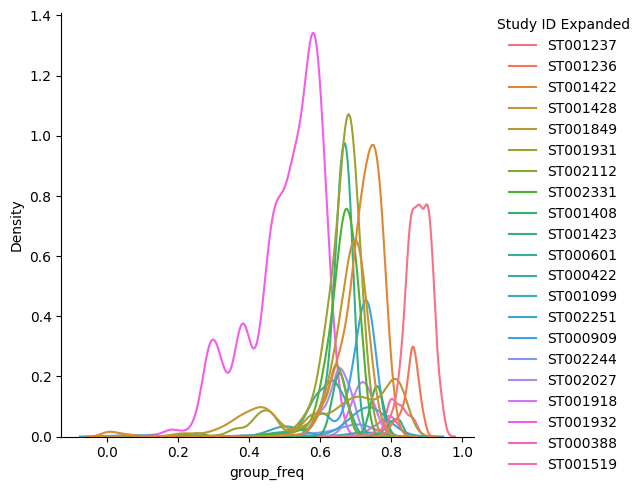

In [66]:
sns.displot(metadata_df, x='group_freq', hue=group_col, kind='kde')

In [72]:
# Frequency of each peak within each group
feat_info = pd.DataFrame()
feat_info.index = nan_mask.index

for group_id, group_feats in group_feats_dict.items():
    group_samples = metadata_df[metadata_df[group_col] == group_id].index
    feat_info[group_id] = nan_mask.loc[group_feats,group_samples].mean(axis=1)

In [78]:
num_samples = metadata_df.groupby(group_col).size()

In [79]:
num_samples

Study ID Expanded
ST000388      95
ST000422      60
ST000601     393
ST000909     744
ST001099     102
ST001236     271
ST001237    1379
ST001408     349
ST001422    2075
ST001423    1197
ST001428    1542
ST001519     166
ST001849     691
ST001918     271
ST001931    2046
ST001932    4488
ST002027     356
ST002112     335
ST002244     122
ST002251     253
ST002331    1322
dtype: int64

In [80]:
feat_info2 = feat_info.copy()
feat_info2 = feat_info2 * num_samples

In [89]:
feat_fewest_samples = feat_info2.min(axis=1)
feat_smallest_freq = feat_info.min(axis=1)

In [90]:
feat_smallest_freq

FT10031    0.126074
FT10035    0.133333
FT10037    0.301205
FT10039    0.124337
FT10040    0.715789
             ...   
FT9988     0.298507
FT9989     0.284314
FT9995     0.294118
FT9997     0.294118
FT9999     0.713115
Length: 3895, dtype: float64

In [93]:
min_num_samples = 10
min_freq = 0.1
feat_ids = feat_info.index
print('number of features before frequency filtering: ', len(feat_ids))

new_feats = feat_ids[(feat_fewest_samples > min_num_samples) & (feat_smallest_freq > min_freq)]
print('number of features after frequency filtering: ', len(new_feats))

# check overlap with Matt features
for matt_ft_name, matt_ft_list in matt_ft_dict.items():
    captured_peaks = get_captured_fts(matt_ft_list, new_feats)
    print(f'Number of {matt_ft_name} captured: {len(captured_peaks)} out of {len(matt_ft_list)}')

number of features before frequency filtering:  3895
number of features after frequency filtering:  3579
Number of top_10 captured: 10 out of 10
Number of top_25 captured: 25 out of 25
Number of 168_os_pfs captured: 158 out of 168
Number of net_matched captured: 82 out of 86
Number of rcc_targets captured: 151 out of 188


In [106]:
out_dct_list = []
for min_num_samples in range(0,40):
# for min_num_samples in [15]:
    for min_freq in [0.1]:
    # for min_freq in [0.1,0.15,0.2,0.25,0.30,0.35]:
        new_feats = feat_ids[(feat_fewest_samples > min_num_samples) & (feat_smallest_freq > min_freq)]
        
        out_dict = {'min_num_samples': min_num_samples, 'min_freq': min_freq, 'num_feats': len(new_feats)}

        for matt_ft_name, matt_ft_list in matt_ft_dict.items():
            captured_peaks = get_captured_fts(matt_ft_list, new_feats)
            out_dict[f'num_{matt_ft_name}'] = len(captured_peaks)
            out_dict[f'frac_{matt_ft_name}'] = len(captured_peaks)/ len(matt_ft_list)
        out_dct_list.append(out_dict)

out_df = pd.DataFrame(out_dct_list)

Text(0, 0.5, 'Fraction of features captured')

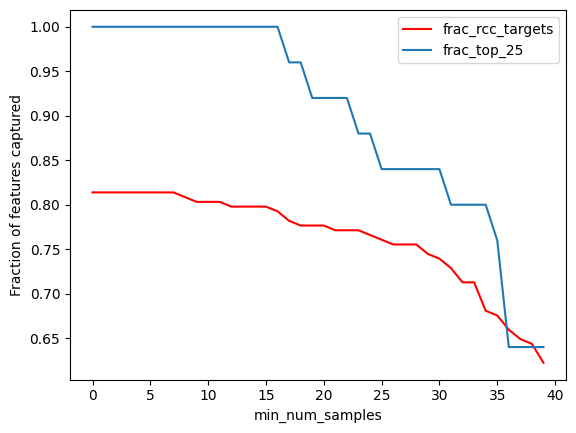

In [107]:
# out_df.plot(x='min_num_samples', y='num_feats', label='num_feats')
ax, fig = plt.subplots()
out_df.plot(x='min_num_samples', y='frac_rcc_targets', label='frac_rcc_targets', kind='line', ax=fig, color='r')
out_df.plot(x='min_num_samples', y='frac_top_25', label='frac_top_25', kind='line', ax=fig)
plt.ylabel('Fraction of features captured')

Text(0, 0.5, 'Fraction of features captured')

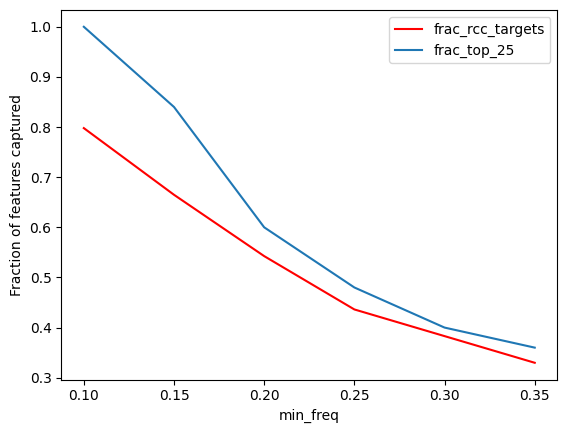

In [105]:
# out_df.plot(x='min_num_samples', y='num_feats', label='num_feats')
ax, fig = plt.subplots()
out_df.plot(x='min_freq', y='frac_rcc_targets', label='frac_rcc_targets', kind='line', ax=fig, color='r')
out_df.plot(x='min_freq', y='frac_top_25', label='frac_top_25', kind='line', ax=fig)
plt.ylabel('Fraction of features captured')

In [96]:
out_df

,min_num_samples,min_freq,num_feats,num_top_10,frac_top_10,num_top_25,frac_top_25,num_168_os_pfs,frac_168_os_pfs,num_net_matched,frac_net_matched,num_rcc_targets,frac_rcc_targets
0,0,0.10,3633,10,1.0,25,1.00,158,0.940476,82,0.953488,153,0.813830
1,0,0.15,2718,10,1.0,21,0.84,125,0.744048,65,0.755814,126,0.670213
2,0,0.20,2079,9,0.9,15,0.60,102,0.607143,49,0.569767,102,0.542553
3,0,0.25,1610,7,0.7,12,0.48,78,0.464286,33,0.383721,82,0.436170
4,0,0.30,1218,6,0.6,10,0.40,61,0.363095,27,0.313953,72,0.382979
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,39,0.15,2010,8,0.8,15,0.60,98,0.583333,49,0.569767,102,0.542553
236,39,0.20,1656,7,0.7,12,0.48,84,0.500000,40,0.465116,85,0.452128
237,39,0.25,1360,6,0.6,11,0.44,69,0.410714,29,0.337209,71,0.377660
238,39,0.30,1133,5,0.5,9,0.36,57,0.339286,24,0.279070,65,0.345745


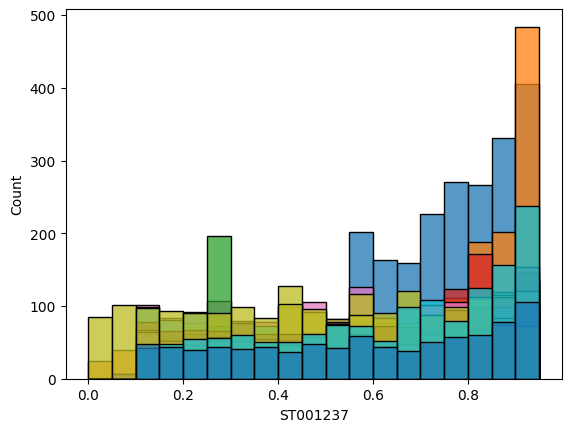

In [77]:
ax, fig = plt.subplots()
for group_id in group_feats_dict.keys():
    sns.histplot(feat_info[group_id], label=group_id, ax=fig, bins=np.arange(0,1,0.05))

In [56]:
len(feat_ids)

3895

In [55]:
len(temp)

2994

In [53]:
group_samples

Index(['HP_mzml/Plasma/0092_WUG_FARMM_HIL-9004-3-PB.mzML',
       'HP_mzml/Plasma/0135_WUG_FARMM_HIL-9009-2-PE.mzML',
       'HP_mzml/Plasma/0139_WUG_FARMM_HIL-9035-3-PE.mzML',
       'HP_mzml/Plasma/0034_WUG_FARMM_HIL-9033-1-PC.mzML',
       'HP_mzml/Plasma/0068_WUG_FARMM_HIL-9016-2-PD.mzML',
       'HP_mzml/Plasma/0111_WUG_FARMM_HIL-9032-2-PA.mzML',
       'HP_mzml/Plasma/0127_WUG_FARMM_HIL-9029-2-PD.mzML',
       'HP_mzml/Plasma/0104_WUG_FARMM_HIL-9008-3-PD.mzML',
       'HP_mzml/Plasma/0126_WUG_FARMM_HIL-9029-2-PB.mzML',
       'HP_mzml/Plasma/0080a_WUG_FARMM_HIL-QPP05.mzML',
       ...
       'HP_mzml/Plasma/0010_WUG_FARMM_HIL-9014-3-PA.mzML',
       'HP_mzml/Plasma/0061_WUG_FARMM_HIL-9019-1-PA.mzML',
       'HP_mzml/Plasma/0054_WUG_FARMM_HIL-9030-1-PB.mzML',
       'HP_mzml/Plasma/0031_WUG_FARMM_HIL-9033-1-PB.mzML',
       'HP_mzml/Plasma/0064_WUG_FARMM_HIL-9019-1-PC.mzML',
       'HP_mzml/Plasma/0073_WUG_FARMM_HIL-9013-2-PE.mzML',
       'HP_mzml/Plasma/0006_WUG_FARMM_HIL-9014-3

In [52]:
feat_ids

Index(['FT10031', 'FT10035', 'FT10037', 'FT10039', 'FT10040', 'FT10041',
       'FT10042', 'FT10043', 'FT10044', 'FT10045',
       ...
       'FT9976', 'FT9978', 'FT9980', 'FT9984', 'FT9985', 'FT9988', 'FT9989',
       'FT9995', 'FT9997', 'FT9999'],
      dtype='object', length=3895)

In [51]:
metadata_df['group_freq'] = group_freq

In [ ]:
metadata_df

In [50]:
for group_id, group_feats in group_feats_dict.items():
    print(group_id, ':', len(group_feats))

ST001237 : 3273
ST001236 : 2932
ST001422 : 3895
ST001428 : 3895
ST001849 : 3828
ST001931 : 3889
ST002112 : 3703
ST002331 : 3887
ST001408 : 3548
ST001423 : 3884
ST000601 : 3802
ST000422 : 3454
ST001099 : 3720
ST002251 : 3879
ST000909 : 3854
ST002244 : 3745
ST002027 : 3737
ST001918 : 3838
ST001932 : 3895
ST000388 : 3447
ST001519 : 2994


In [37]:
group_feats_dict.keys()

dict_keys(['ST001237', 'ST001236', 'ST001422', 'ST001428', 'ST001849', 'ST001931', 'ST002112', 'ST002331', 'ST001408', 'ST001423', 'ST000601', 'ST000422', 'ST001099', 'ST002251', 'ST000909', 'ST002244', 'ST002027', 'ST001918', 'ST001932', 'ST000388', 'ST001519'])

In [26]:
nan_mask[group_samples].any(axis=1)

FT10031    True
FT10035    True
FT10037    True
FT10039    True
FT10040    True
           ... 
FT9988     True
FT9989     True
FT9995     True
FT9997     True
FT9999     True
Length: 3895, dtype: bool

In [22]:
len(study_samples)

1379

In [ ]:
group_freq_dct = {}
group_sz_dct = {}
for group_id in metadata_df[group_col].unique():
    group_samples = metadata_df[metadata_df[group_col]==group_id].index
    val = 1 - nan_mask[group_samples].mean(axis=1)
    group_freq_dct[group_id] = val
    group_sz_dct[group_id] = len(group_samples)

group_freq_df = pd.DataFrame(group_freq_dct)
group_sz_df = pd.DataFrame(group_sz_dct, index=['Number of Samples']).T

In [ ]:
metadata_summary['Number of Samples'].sum()

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
temp = metadata_summary.groupby('Cohort Label')['Number of Samples'].sum().sort_values(ascending=False)
temp.plot(kind='bar', ax=ax, color=[cohort_label_to_color[label] for label in temp.index])
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples in Each Cohort Label')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
temp = metadata_summary.groupby('Study ID')['Number of Samples'].sum().sort_values(ascending=False)
temp.plot(kind='bar', ax=ax, color=[study_id_to_color[label] for label in temp.index])
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples in Each Study ID')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=metadata_summary, x='Cohort ID', y='Alignment Score', palette=cohort_label_to_color, hue='Cohort Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('Alignment Score')
ax.set_title('Alignment Score in Each Cohort')
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
metadata_summary

## Main Analysis

In [ ]:
def compute_peak_robustness(alignment_df, nan_mask, metadata_summary,metadata_df,
                            ref_id=ref_cohort_id,group_col='Study ID Expanded'):

    # num_samples = metadata_df[group_col].value_counts()

    num_samples = metadata_summary[['Cohort ID','Number of Samples']].copy()
    num_samples.set_index('Cohort ID', inplace=True)
    total_num_samples = num_samples['Number of Samples'].sum()
    align_summary =  alignment_df.copy()
    align_summary.index = align_summary[ref_id]
    # align_summary.set_index(ref_id, inplace=True)

    nan_locs = align_summary.isna()
    ref_fts = align_summary.index

    for col in align_summary.columns:
        align_summary[col] = ref_fts

    align_summary[nan_locs] = None
    align_summary = align_summary.astype(bool).astype(int).T
    align_summary.index.name = 'Cohort ID'

    align_summary_cohortsize_weighted = align_summary.mul(num_samples['Number of Samples'], axis=0)

    # weight is by the size of the cohort
    peak_robustness_1 = align_summary_cohortsize_weighted.sum(axis=0)/total_num_samples

    # each cohort is weighted equally
    peak_robustness_2 = align_summary.sum(axis=0)/align_summary.shape[0]

    # each weight is by the log(size) of the cohort
    align_summary_logcohortsize_weighted = np.log(1 + align_summary_cohortsize_weighted)
    log_tot_num_samples = np.sum(1+ np.log(num_samples['Number of Samples']))
    peak_robustness_3 = align_summary_logcohortsize_weighted.sum(axis=0)/log_tot_num_samples


    # the peak frequency across the cohorts
    # cohort_peak_frequency = nan_mask.sum(axis=1)

    group_freq_dct = {}
    group_sz_dct = {}
    for group_id in metadata_df[group_col].unique():
        cohort_samples = metadata_df[metadata_df[group_col]==group_id].index
        val = 1 - nan_mask[cohort_samples].mean(axis=1)
        group_freq_dct[group_id] = val
        group_sz_dct[group_id] = len(cohort_samples)

    group_freq_df = pd.DataFrame(group_freq_dct)
    group_sz_df = pd.DataFrame(group_sz_dct, index=['Number of Samples']).T

    # the peak frequency across the group, each group weighted by size
    peak_robustness_4 = group_freq_df.mul(group_sz_df['Number of Samples'], axis=1).sum(axis=1)/group_sz_df['Number of Samples'].sum()
    

    # the peak frequency across the group, each group weighted by log(size)
    group_log_sz_df = np.log(1 + group_sz_df)
    log_group_sz_df = group_freq_df.mul(group_log_sz_df['Number of Samples'], axis=1).sum(axis=1)/group_log_sz_df['Number of Samples'].sum()
    peak_robustness_5 = log_group_sz_df


    peak_robustness_dct = {
        'Found, Cohort Equal Weighted': peak_robustness_2,
        'Found, Cohort Size Weighted': peak_robustness_1,
        'Found, Cohort Log Size Weighted': peak_robustness_3,
        'Freq, Cohort Size Weighted': peak_robustness_4,
        'Freq, Cohort Log Size Weighted': peak_robustness_5
    }

    return peak_robustness_dct

In [ ]:
nan_mask = pd.read_csv(nan_mask_file, index_col=0)
nan_mask.columns = nan_mask.columns.astype(str)

In [ ]:
# Load the original alignment summary
alignment_df = pd.read_csv(align_feats_file)
alignment_df.columns = alignment_df.columns.astype(str)
alignment_df.dropna(axis=0, how='all', inplace=True)
alignment_df = alignment_df[metadata_summary['Cohort ID'].unique()]

# %% Compute different peak robustness scores
nan_mask = nan_mask[metadata_df.index]

# %%
peak_robustness_dct = compute_peak_robustness(alignment_df, nan_mask, metadata_summary, metadata_df)


In [ ]:
robustness_df = pd.DataFrame(peak_robustness_dct)
robustness_df.to_csv(os.path.join(data_dir, 'peak_robustness.csv'))

In [ ]:
feat_info = pd.DataFrame(index=alignment_df[ref_cohort_id])
feat_info.index.name = 'Aligned Features'
for k,v in matt_ft_dict.items():
    feat_info[k] = False
    overlap = [x for x in v if x in feat_info.index]
    print(f'From {k} there are {len(overlap)} aligned out of {len(v)} features.')
    feat_info.loc[overlap, k] = True

In [ ]:
group_col = 'cohort_id'    
group_freq_dct = {}
group_sz_dct = {}
for group_id in metadata_df[group_col].unique():
    cohort_samples = metadata_df[metadata_df[group_col]==group_id].index
    val = 1 - nan_mask[cohort_samples].mean(axis=1)
    group_freq_dct[group_id] = val
    group_sz_dct[group_id] = len(cohort_samples)

group_freq_df = pd.DataFrame(group_freq_dct)
group_sz_df = pd.DataFrame(group_sz_dct, index=['Number of Samples']).T

feat_info = feat_info.join(group_freq_df)

In [ ]:
group_sz_df

In [ ]:
col_cluster = False
row_cluster = False

cohort_ids = metadata_df['cohort_id'].unique()
plot_df = feat_info[cohort_ids].T

col_colors = pd.DataFrame(index=plot_df.columns)
for col in feat_info.columns:
    if col in cohort_ids:
        continue
    col_colors[col] = feat_info[col].map({True: 'black', False: 'white'})

col_colors['Robustness'] = peak_robustness_dct['Found, Cohort Size Weighted'].map(lambda x: plt.cm.plasma(x))
col_colors['Pass Threshold'] = (peak_robustness_dct['Found, Cohort Size Weighted'] > 0.25).map({True: 'black', False: 'white'})

####
# Change the names of the rows
cohort_id_to_sample_num = metadata_summary[['Cohort ID','Number of Samples']].copy()
cohort_id_to_sample_num.set_index('Cohort ID', inplace=True)
align_summary_bool = ~alignment_df.isna()
align_counts = align_summary_bool.sum(axis=0)

if col_cluster==False:
    col_val_order = peak_robustness_dct['Found, Cohort Size Weighted']
    col_val_order.sort_values(ascending=False, inplace=True)
    plot_df = plot_df[col_val_order.index]

if row_cluster==False:
    row_val_order = group_sz_df['Number of Samples'].copy()
    row_val_order.sort_values(ascending=False, inplace=True)
    plot_df = plot_df.loc[row_val_order.index]


row_colors = pd.DataFrame(index=plot_df.index)
row_colors['Cohort Label'] = [cohort_id_to_color[c] for c in plot_df.index]
row_colors['Cohort Size'] = [group_sz_df.loc[c, 'Number of Samples'] for c in plot_df.index]
row_colors['Cohort Size'] = row_colors['Cohort Size']/row_colors['Cohort Size'].max()
row_colors['Cohort Size'] = row_colors['Cohort Size'].map(lambda x: plt.cm.copper_r(x))




new_row_names = [f'{c} (Nfiles={cohort_id_to_sample_num.loc[c].values[0]}, Npeaks={align_counts[c]:.0f}, Align%={cohort_id_to_align_score[c]:.2f})' 
        for c in plot_df.index]





plot_df.index =  new_row_names
row_colors.index = new_row_names

g = sns.clustermap(plot_df, cmap='viridis', figsize=(50,20), 
            row_colors=row_colors, col_colors=col_colors, 
            col_cluster=col_cluster, row_cluster=row_cluster,
            dendrogram_ratio=0.04)

plt.setp(g.ax_heatmap.get_xticklabels(), visible=False)
# add a label to the colorbar 
g.cax.set_ylabel('Peak Frequency')



plt.savefig(os.path.join(save_dir, 'supervenn_clustermap.png'), **savefig_params)

In [ ]:
col_cluster = False
row_cluster = False

cohort_ids = metadata_df['cohort_id'].unique()
plot_df = feat_info[cohort_ids].T

col_colors = pd.DataFrame(index=plot_df.columns)
for col in feat_info.columns:
    if col in cohort_ids:
        continue
    col_colors[col] = feat_info[col].map({True: 'black', False: 'white'})

col_colors['Robustness'] = peak_robustness_dct['Found, Cohort Size Weighted'].map(lambda x: plt.cm.plasma(x))
col_colors['Pass Threshold'] = (peak_robustness_dct['Found, Cohort Size Weighted'] > 0.25).map({True: 'black', False: 'white'})

####
# Change the names of the rows
cohort_id_to_sample_num = metadata_summary[['Cohort ID','Number of Samples']].copy()
cohort_id_to_sample_num.set_index('Cohort ID', inplace=True)
# align_summary_bool = alignment_df.astype(bool)
align_summary_bool = ~alignment_df.isna()
align_counts = align_summary_bool.sum(axis=0)

if col_cluster==False:
    col_val_order = peak_robustness_dct['Found, Cohort Size Weighted']
    col_val_order.sort_values(ascending=False, inplace=True)
    plot_df = plot_df[col_val_order.index]

if row_cluster==False:
    row_val_order = group_sz_df['Number of Samples'].copy()
    row_val_order.sort_values(ascending=False, inplace=True)
    plot_df = plot_df.loc[row_val_order.index]


row_colors = pd.DataFrame(index=plot_df.index)
row_colors['Cohort Label'] = [cohort_id_to_color[c] for c in plot_df.index]
row_colors['Cohort Size'] = [group_sz_df.loc[c, 'Number of Samples'] for c in plot_df.index]
row_colors['Cohort Size'] = row_colors['Cohort Size']/row_colors['Cohort Size'].max()
row_colors['Cohort Size'] = row_colors['Cohort Size'].map(lambda x: plt.cm.copper_r(x))




new_row_names = [f'{c} (Nfiles={cohort_id_to_sample_num.loc[c].values[0]}, Npeaks={align_counts[c]:.0f}, Align%={cohort_id_to_align_score[c]:.2f})' 
        for c in plot_df.index]





plot_df.index =  new_row_names
row_colors.index = new_row_names

g = sns.clustermap(plot_df, cmap='viridis', figsize=(8,8), 
            row_colors=row_colors, col_colors=col_colors, 
            col_cluster=col_cluster, row_cluster=row_cluster,
            dendrogram_ratio=0.1)

plt.setp(g.ax_heatmap.get_xticklabels(), visible=False)
# add a label to the colorbar 
g.cax.set_ylabel('Peak Frequency')


In [ ]:
savefig_params

In [ ]:
# feat_info_2 = feat_info.copy()
# feat_info_2['label'] = 'others'
# feat_info_2.loc[feat_info_2['168_os_pfs'], 'label'] = '168_os_pfs'
# feat_info_2.loc[feat_info_2['net_matched'], 'label'] = 'net_matched'
# feat_info_2.loc[feat_info_2['top_25'], 'label'] = 'top_25'

# for k,v in peak_robustness_dct.items():
#     feat_info_2[k] = v




feat_info_2 = feat_info.copy()
feat_info_2['label'] = 'others'
feat_info_2.loc[feat_info_2['rcc_targets'], 'label'] = 'rcc_targets'
feat_info_2.loc[feat_info_2['net_matched'], 'label'] = 'net_matched'
feat_info_2.loc[feat_info_2['top_25'], 'label'] = 'top_25'

for k,v in peak_robustness_dct.items():
    feat_info_2[k] = v    

In [ ]:
for k in peak_robustness_dct.keys():

    # fig, ax = plt.subplots(figsize=(8,6))
    sns.displot(data=feat_info_2, x=k, hue='label', fill=True, multiple='stack')
    ax.set_title(k)
    plt.savefig(os.path.join(save_dir, f'x_{k}_hist.png'), **savefig_params)
    plt.close()

    # fig, ax = plt.subplots(figsize=(8,6))
    sns.displot(data=feat_info_2, x=k, hue='label', fill=True, kind='kde', common_norm=False, bw_adjust=0.5)
    ax.set_title(k)
    plt.savefig(os.path.join(save_dir, f'x_{k}_kde.png'), **savefig_params)
    plt.close()


In [ ]:
# sns.displot(data=feat_info_2, x='Found, Cohort Size Weighted', hue='label', fill=True, multiple='stack')

In [ ]:
sns.displot(data=feat_info_2, x='Found, Cohort Size Weighted', hue='label', fill=True, kind='kde', common_norm=False, bw_method=0.25)

In [ ]:
matt_ft_dict.keys()

In [ ]:
robustnesss_thresholds = [0,0.05,0.1,0.15,0.2,0.25,0.3, 0.33, 0.35, 0.4, 0.45, 0.5]
captured_info_list = []
chosen_robustness_metric = 'Found, Cohort Size Weighted'
for threshold in robustnesss_thresholds:

    captured_peaks = feat_info_2[feat_info_2[chosen_robustness_metric] > threshold].index

    captured_info = {
        'robustness threshold': threshold,
        'number of peaks': len(captured_peaks),
        # '% of RCC peaks': get_captured_perc(rcc_peak_info_df.index, captured_peaks)[0],
        '% of RCC peaks': len(captured_peaks)/num_ref_cohort_peaks,
        '% of Matt top 25': get_captured_perc(matt_ft_dict['top_25'], captured_peaks)[0],
        '% of network peaks': get_captured_perc(matt_ft_dict['net_matched'], captured_peaks)[0],
        '% of RCC targets': get_captured_perc(matt_ft_dict['rcc_targets'], captured_peaks)[0],
    }

    captured_info_list.append(captured_info)
    print(f'Number of peaks with robustness greater than {threshold}: ', (feat_info_2[chosen_robustness_metric] > threshold).sum())


captured_df = pd.DataFrame(captured_info_list)

In [ ]:
captured_df

In [ ]:
rcc_metadata_file = os.path.join(dropbox_dir, 'development_CohortCombination','clean_rcc_metadata.csv')

desc_str = 'x'
rcc_metadata = pd.read_csv(rcc_metadata_file, index_col=0)
metadata = pd.read_csv(os.path.join(data_dir, 'subset_metadata.csv'), index_col=0)
peak_robustness = pd.read_csv(os.path.join(data_dir, 'peak_robustness.csv'), index_col=0)
# Join the two metadata together
metadata = metadata.join(rcc_metadata, how='outer')
metadata.to_csv(os.path.join(data_dir, 'subset_metadata_with_rcc.csv'))
robust_score = peak_robustness['Found, Cohort Size Weighted']
keep_peaks = peak_robustness[robust_score >=0.25].index
keep_samples = metadata.index

print(f'Keeping {len(keep_peaks)} peaks and {len(keep_samples)} samples')
# data_corrected = pd.read_csv(os.path.join(data_dir, 'subset_data_corrected.csv'), index_col=0)
# nan_mask = pd.read_csv(os.path.join(data_dir, 'subset_nan_mask.csv'), index_col=0)

combined_study = pd.read_csv(os.path.join(data_dir, 'combined_study.csv'), index_col=0)
nan_mask = pd.read_csv(os.path.join(data_dir, 'combined_study_nan_mask.csv'), index_col=0)
combined_study.columns = combined_study.columns.astype(str)
nan_mask.columns = nan_mask.columns.astype(str)
combined_study = combined_study.loc[keep_peaks, keep_samples].copy()
nan_mask = nan_mask.loc[keep_peaks, keep_samples].copy()



metadata['MV'] = 100*nan_mask.sum(axis=0)/nan_mask.shape[0]



        # %%
num_missing_vals = nan_mask.sum(axis=0).sort_values(ascending=False)
num_missing_frac = num_missing_vals/combined_study.shape[0]

# fig, ax = plt.subplots(figsize=(6,4))
# sns.histplot(num_missing_frac, bins=np.linspace(0,1,21), ax=ax)
# plt.xlabel('Missing Value Fraction')
# plt.ylabel('Number of Samples')
# plt.title('Histogram of Missing Value Fraction')
# plt.savefig(os.path.join(save_dir, f'missing_value_fraction_hist_subset_{min_num_cohort_ids}.png'), **savefig_params)
# plt.close()

# %%
# Remove samples with more than 95% missing values
mis_val_frac_th = 0.95
print(f'number of samples with more than {100*mis_val_frac_th:.0f}% missing values: ', (num_missing_frac > mis_val_frac_th).sum())
kept_samples = num_missing_frac[num_missing_frac < mis_val_frac_th].index
nan_mask = nan_mask.loc[:,kept_samples]
combined_study = combined_study.loc[:,kept_samples]
subset_metadata = metadata.loc[kept_samples]
cohort_id_list = subset_metadata['Cohort ID Expanded'].tolist()

print('combined_study shape after removing samples with more than 95% missing values: ', combined_study.shape)

# %%
# If we want to fill the NA values with something else
combined_study[nan_mask] = np.nan
# we want to split up the RCC cohorts into its subsets
combined_study = fill_na_by_cohort(combined_study, cohort_id_list, method= 'mean_1th')

# %%
data_corrected = standardize_across_cohorts(combined_study, cohort_id_list, method='zscore')
print('data_corrected shape: ', data_corrected.shape)
# which columns have been removed?
rem_cols = data_corrected.isna().sum() > 0
rem_cols = rem_cols[rem_cols].index
print('Number of columns removed: ', rem_cols.shape[0])
print('Columns removed: ', rem_cols)
data_corrected.dropna(axis=1, inplace=True)
print('data_corrected shape after dropping NA columns: ', data_corrected.shape)
subset_metadata = subset_metadata.loc[data_corrected.columns]
# Choose to look at only a subset of the data

# subset_metadata = metadata[metadata['Cohort Label'].isin(['adult_cancer','adult_other'])].copy()
subset_nan_mask = nan_mask[subset_metadata.index]

# successively remove the worst samples and features based on the nan_mask
# for thresh in [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]:
for thresh in [0.95, 0.9]:
    subset_nan_mask = subset_nan_mask[subset_metadata.index]
    good_samples = subset_nan_mask.sum(axis=0) < subset_nan_mask.shape[0]*thresh
    subset_nan_mask = subset_nan_mask[good_samples[good_samples].index]
    good_features = subset_nan_mask.sum(axis=1) < subset_nan_mask.shape[1]*thresh
    subset_nan_mask = subset_nan_mask.loc[good_features[good_features].index]
    subset_metadata = subset_metadata.loc[subset_nan_mask.columns]
    print(subset_nan_mask.shape)

# Assign the new subsets to overwrite the original data
if True:
    subset_dir = os.path.join(data_dir, 'subset_'+desc_str)
    os.mkdir(subset_dir)

    data_corrected = data_corrected.loc[subset_nan_mask.index, subset_nan_mask.columns]
    nan_mask = nan_mask.loc[subset_nan_mask.index, subset_nan_mask.columns]
    metadata = metadata.loc[subset_nan_mask.columns]
    print(metadata.shape, data_corrected.shape, nan_mask.shape)


    # remove the features with zero variance
    # good_features2 = data_corrected.var(axis=1) > 0
    # good_features2= good_features2[good_features2].index
    # data_corrected = data_corrected.loc[good_features2]
    # nan_mask = nan_mask.loc[good_features2]
    # print(metadata.shape, data_corrected.shape, nan_mask.shape)

    # (data_corrected.T).to_csv(os.path.join(subset_dir, 'X.csv'))
    # metadata.to_csv(os.path.join(subset_dir, 'y.csv'))
    # (nan_mask.T).to_csv(os.path.join(subset_dir, 'nans.csv'))

In [ ]:
def create_plot(plot_df, hue_col, palette_dict,include_MV=True,sz=None):
    if 'UMAP1' in plot_df.columns:
        x_col = 'UMAP1'
        y_col = 'UMAP2'
    else:
        x_col = 'PC1'
        y_col = 'PC2'

    if sz is None:
        sz = 10/np.log2(plot_df.shape[0])
        print('marker size: ', sz)

    fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(data=plot_df, x=x_col, y=y_col, hue=hue_col, palette=palette_dict, ax=ax, s=sz)
    
        # place the legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # edit the legend to include the number of samples in each cohort
    handles, labels = ax.get_legend_handles_labels()
    if include_MV:
        labels = [f'{label} (N={plot_df[plot_df[hue_col]==label].shape[0]}, MV%={plot_df[plot_df[hue_col]==label]["MV"].mean():.0f})' for label in labels]
    else:
        labels = [f'{label} (N={plot_df[plot_df[hue_col]==label].shape[0]})' for label in labels]

    # make the size of the markers in the handles larger
    for handle in handles:
        # print(dir(handle))
        handle.set_markersize(10)
        # handle._sizes = [100]
    
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return fig, ax

In [ ]:
import umap
from sklearn.decomposition import PCA

In [ ]:
subset_id = 'x'

In [ ]:
pca_file_subset = os.path.join(data_dir, f'pca_df_zscore_subset_{subset_id}.csv')

pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_corrected.T)
pca_df = pd.DataFrame(pca_result, index=data_corrected.columns, columns=['PC1', 'PC2'])
pca_df['MV'] = subset_metadata['MV']
pca_df['Cohort Label'] = subset_metadata['Cohort Label']
pca_df['Study ID'] = subset_metadata['Study ID']
pca_df['Cohort ID'] = subset_metadata['cohort_id']

# save the pca_df
pca_df.to_csv(pca_file_subset)

In [ ]:
create_plot(pca_df, 'Cohort Label', cohort_label_to_color)
plt.xlim([-100,100])
plt.ylim([-50,50])

In [ ]:
create_plot(pca_df, 'Study ID', study_id_to_uniq_color)
plt.xlim([-100,100])
plt.ylim([-50,50])

In [ ]:

# %%
create_plot(pca_df, 'Cohort Label', cohort_label_to_color)
plt.savefig(os.path.join(save_dir, f'pca_cohort_label_subset_{subset_id}.png'), **savefig_params)
plt.close()

# error occurs here?
create_plot(pca_df, 'Study ID', study_id_to_uniq_color)
plt.savefig(os.path.join(save_dir, f'pca_study_id_uniq_color_subset_{subset_id}.png'), **savefig_params)
plt.close()

# %% [markdown]

In [ ]:
# ### UMAP Plot
umap_file_subset = os.path.join(data_dir, f'umap_df_zscore_subset_{subset_id}.csv')


# %%
umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(data_corrected.T)

In [ ]:
data_corrected.shape

In [ ]:
umap_df = pd.DataFrame(umap_result, index=data_corrected.columns, columns=['UMAP1', 'UMAP2'])
umap_df['MV'] = subset_metadata['MV']
umap_df['Cohort Label'] = subset_metadata['Cohort Label']
umap_df['Study ID'] = subset_metadata['Study ID']
umap_df['Cohort ID'] = subset_metadata['cohort_id']

# save the umap_df
umap_df.to_csv(umap_file_subset)

In [ ]:
create_plot(umap_df, 'Cohort Label', cohort_label_to_color)

In [ ]:
create_plot(umap_df, 'Study ID', study_id_to_uniq_color)
# plt.savefig(os.path.join(save_dir, f'umap_study_id_uniq_color_subset_{min_num_cohort_ids}.png'), **savefig_params)
# plt.close()

In [ ]:
create_plot(umap_df, 'Study ID', study_id_to_uniq_color)
plt.xlim([2.5,15])
plt.ylim([5,10])

In [ ]:
cohort_id_to_uniq_color
